C:\Users\Zeng\AppData\Local\Temp\ipykernel_21308\3457058458.py:19: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  super().__init__()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: x and y must have same first dimension, but have shapes (167,) and (166,)

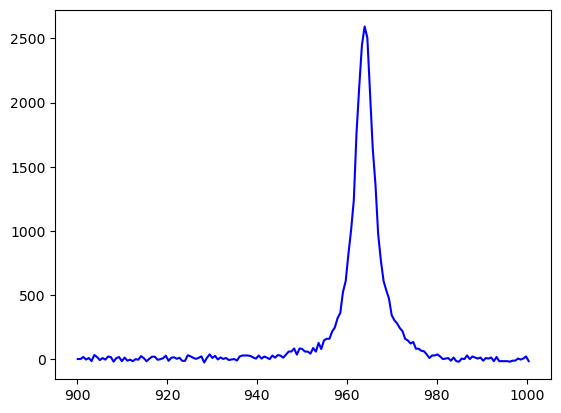

In [1]:
from PyQt6.QtWidgets import (
    QApplication,
    QMainWindow,
    QFileDialog,
    QGraphicsScene,
    QGraphicsPixmapItem,
    QTableWidgetItem,
    QMessageBox  # 添加这一行
)
from PyQt6.QtGui import QImage, QPixmap
from PyQt6.QtCore import Qt
from Ui_RamanFWHM import Ui_RamanFWHM
from functions import data_load, rawdata_heatmap, rawdata_spectral, pipline_choice, data_process, processed_spectral, fwhm_heatmap
import os


class MyMainWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.ui = Ui_RamanFWHM()
        self.ui.setupUi(self)
        self.rawdata = None  # 初始化为 None
        self.x = None
        self.y = None
        self.unique_x = None
        self.unique_y = None
        self.processed_data = []
        self.processed_datanpy = None
        self.setup_ui()
        
    def setup_ui(self):
        self.ui.Fileselectbutton.clicked.connect(self.select_file)
        self.ui.AxisList.currentItemChanged.connect(self.show_rawdata_map)
        self.ui.XList.currentItemChanged.connect(self.show_rawdata_spectral)
        self.ui.YList.currentItemChanged.connect(self.show_rawdata_spectral)
        self.ui.Begin_Pro.clicked.connect(self.begin_processing)

    def select_file(self):
        file_dialog = QFileDialog()
        file_path, _ = file_dialog.getOpenFileName(self, "Select File")

        if file_path:
            file_name = os.path.basename(file_path)
            (
                self.x,
                self.y,
                self.unique_x,
                self.unique_y,
                xnum,
                ynum,
                axis,
                self.rawdata,
            ) = data_load(file_path)  # 使用 self.rawdata

            self.ui.DataRowsCols.setText(f"data contains {xnum}(x)*{ynum}(y) points")
            self.ui.SelectedFileBrowser.setText(f"Selected File: {file_name}")

            # 清空 AxisList、XList、YList 中的所有项目
            self.ui.AxisList.clear()
            self.ui.XList.clear()
            self.ui.XList_2.clear()
            self.ui.YList.clear()
            self.ui.YList_2.clear()

            for value in axis:
                # 添加项目
                self.ui.AxisList.addItem(str(value))

            for value in self.unique_x:
                # 添加项目
                self.ui.XList.addItem(str(value))
                self.ui.XList_2.addItem(str(value))

            for value in self.unique_y:
                # 添加项目
                self.ui.YList.addItem(str(value))
                self.ui.YList_2.addItem(str(value))

            # 默认选择第一个值
            self.ui.AxisList.setCurrentRow(0)
            self.ui.XList.setCurrentRow(0)
            self.ui.YList.setCurrentRow(0)

            # 调用 show_rawdata_spectral
            self.show_rawdata_spectral()
            self.show_rawdata_map()

    def show_rawdata_map(self, current=None, previous=None):
        if current is None and self.ui.AxisList.count() > 0:
        # 如果没有选定项，并且 AxisList 中有项目，则选择第一个项
            current = self.ui.AxisList.item(0)

        if current is not None and self.rawdata is not None:  
        # 其余代码保持不变
            selected_value = float(current.text())

            # 调用 rawdata_map 函数保存图像
            save_path = rawdata_heatmap(selected_value, self.rawdata)

            # 清空 QGraphicsView 中的内容
            self.ui.Rawmap.setScene(None)

            # 读取图像文件并在 QGraphicsView 中显示
            image = QImage(save_path)
            pixmap = QPixmap.fromImage(image)
            item = QGraphicsPixmapItem(pixmap)

            # 创建 Scene 并添加 Item
            scene = QGraphicsScene(self)
            scene.addItem(item)

            # 设置 Scene 到 QGraphicsView
            self.ui.Rawmap.setScene(scene)
            self.ui.Rawmap.show()

            # 设置 RawmapPeak 标签的文本
            self.ui.RawmapPeak.setText(
                f"<html><b><font color='red'>Current Peak:</font></b> {selected_value}</html>"
            )

    def show_rawdata_spectral(self):
        x_item = self.ui.XList.currentItem()
        y_item = self.ui.YList.currentItem()

        if x_item is not None and y_item is not None:
            x = float(x_item.text())
            y = float(y_item.text())
            rawdata_spectral(x, y, self.rawdata)

            # 显示 rawdata_spectral.png 在 RawdataSpec 中
            save_path = os.path.join(os.getcwd(), 'Figures', 'rawdata_spectral.png')
            image = QImage(save_path)
            pixmap = QPixmap.fromImage(image)
            item = QGraphicsPixmapItem(pixmap)

            # 创建 Scene 并添加 Item
            scene = QGraphicsScene(self)
            scene.addItem(item)

            # 设置 Scene 到 QGraphicsView
            self.ui.RawdataSpec.setScene(scene)
            
            # 自动适应视图大小
            # self.ui.RawdataSpec.fitInView(scene.sceneRect(), Qt.AspectRatioMode.KeepAspectRatio)

            self.ui.RawdataSpec.show()

            # 设置 RawmapPeak 标签的文本
            self.ui.RawXYPosition.setText(
                f"<html><head/><body><p><span style=\" font-weight:700; color:#ff0000;\">Current X: </span><span style=\" font-weight:700; color:#000000;\">{x}</span></p><p><span style=\" font-weight:700; color:#ff0000;\">Current Y: </span><span style=\" font-weight:700; color:#000000;\">{y}</span></p></body></html>"
            )

    def begin_processing(self):
        # 获取用户选择的参数
        choice_crop = self.ui.CropOrNot.isChecked()
        choice_cosmic = self.ui.Choice_Cosmic.isChecked()
        choice_baseline = self.ui.Choice_Baseline.isChecked()
        choice_norm = self.ui.Choice_Normalization.isChecked()
        choice_denoise = self.ui.Choice_Denoise.isChecked()

        # 获取用户输入的 Cropmin 和 Cropmax
        peak_min = self.ui.Cropmin.toPlainText()
        peak_max = self.ui.Cropmax.toPlainText()

        # 检查用户选择了 CropOrNot 时是否输入了 Cropmin 和 Cropmax
        if choice_crop and (not peak_min or not peak_max):
            QMessageBox.warning(self, 'Warning', 'Please input your wanted cropping peak min and max')
            return  # 如果没有输入 Cropmin 和 Cropmax，则停止处理

        # 调用 functions.py 中的 pipline_choice 函数
        pipe = pipline_choice(choice_crop, peak_min, peak_max, choice_cosmic, choice_baseline, choice_norm, choice_denoise)
        
        # 运行 Pipeline
        if pipe is None:
            QMessageBox.warning(self, 'Warning', 'No method was selected')
            return  # 如果没有选择任何方法，则停止处理
        
        self.processed_data = data_process(self.rawdata,pipe)

        # 获取 Figures 文件夹的路径
        figures_folder = os.path.join(os.getcwd(), 'Figures')

        # 在 Figures 文件夹中创建 processed 文件夹
        processed_folder = os.path.join(figures_folder, 'processed')
        os.makedirs(processed_folder, exist_ok=True)

        # 将 processed_data 传入 fwhm_heatmap 函数
        fwhm_image_path = fwhm_heatmap(self.processed_data)

        # 显示 fwhm 图像在 ProMap QGraphicsView 中
        fwhm_image = QImage(fwhm_image_path)
        fwhm_pixmap = QPixmap.fromImage(fwhm_image)
        fwhm_item = QGraphicsPixmapItem(fwhm_pixmap)
        fwhm_scene = QGraphicsScene(self)
        fwhm_scene.addItem(fwhm_item)
        self.ui.ProMap.setScene(fwhm_scene)
        self.ui.ProMap.show()

        # 获取用户选择的 X 和 Y 值
        x_item = self.ui.XList_2.currentItem()
        y_item = self.ui.YList_2.currentItem()

        if x_item is None or y_item is None:
            # 如果用户没有选择 X 和 Y 值，默认选择 XList_2 和 YList_2 中的第一个值
            x_item = self.ui.XList_2.item(0)
            y_item = self.ui.YList_2.item(0)

        # 获取选定的 X 和 Y 值
        selected_x = float(x_item.text())
        selected_y = float(y_item.text())

        # 将选定的 X 和 Y 值传入 processed_spectral 函数
        spectral_image_path = processed_spectral(selected_x, selected_y, self.processed_data)

        # 显示 processed_spectral 图像在 ProSpectral QGraphicsView 中
        spectral_image = QImage(spectral_image_path)
        spectral_pixmap = QPixmap.fromImage(spectral_image)
        spectral_item = QGraphicsPixmapItem(spectral_pixmap)
        spectral_scene = QGraphicsScene(self)
        spectral_scene.addItem(spectral_item)
        self.ui.ProSpectral.setScene(spectral_scene)
        self.ui.ProSpectral.show()

if __name__ == "__main__":
    app = QApplication([])
    window = MyMainWindow()
    window.show()
    app.exec()
